In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:

adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11L12-109\\V11L12-109_A1\\output_data\\V11L12-109_A1_MSI\\V11L12-109_A1.Visium.FMP.220826_smamsi.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11L12-109\\V11L12-109_D1\\output_data\\V11L12-109_D1\\outs\\V11L12-109_D1.h5ad")

In [5]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata2)
print(adata1)
print(idx_to_remove.index)

AnnData object with n_obs × n_vars = 1463 × 14369
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 2438 × 1538
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index([], dtype='object')


C:\Users\28123\AppData\Local\Temp\ipykernel_5552\2788546665.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs["leiden"] = adata1.obs["clusters"]


In [4]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [49]:
##first select random 2200 indices
selected_indices = np.random.choice(2438, 1463, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 3] = 10
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, 10)] = 11
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 3] = 10
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, 10)] = 11

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 3] = 10
X2_label[X2_label == 1] = 10
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label,10)] = 11

[11 11 11 ... 11 11 11]


In [50]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
#data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)


<bound method NDFrame.head of         0         1
0    -1.0  0.558824
1    -1.0  0.588235
2    -1.0  0.617647
3    -1.0  0.647059
4    -1.0  0.676471
...   ...       ...
2433  1.0 -0.441176
2434  1.0 -0.411765
2435  1.0 -0.382353
2436  1.0 -0.352941
2437  1.0 -0.323529

[2438 rows x 2 columns]>
<bound method NDFrame.head of              0         1
1291 -0.019608  0.794118
474  -0.568627  0.794118
30   -0.960784  0.676471
1198 -0.058824 -0.205882
1418  0.098039 -0.676471
...        ...       ...
1304  0.019608 -0.588235
1543  0.176471 -0.382353
1721  0.294118  0.000000
267  -0.725490  0.823529
1507  0.137255  0.235294

[1463 rows x 2 columns]>


In [51]:
cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
data1_spatial_results = cca.transform(data1_spatial_results)
data2_spatial_results = cca.transform(data2_spatial_results)
data3_spatial_results = cca.transform(data3_spatial_results)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)

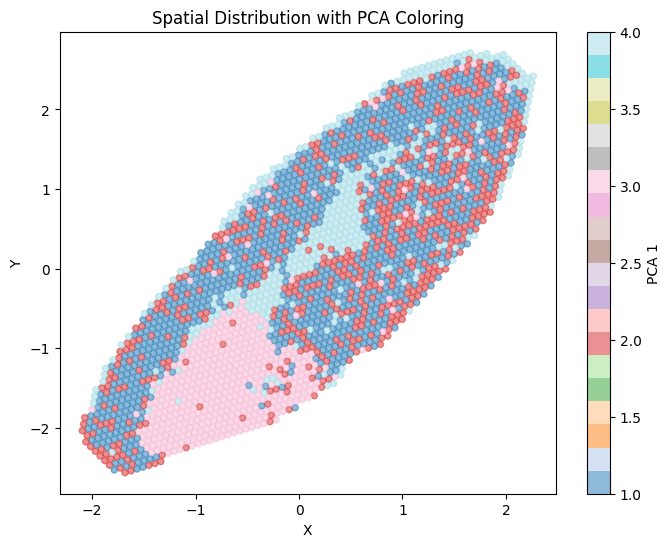

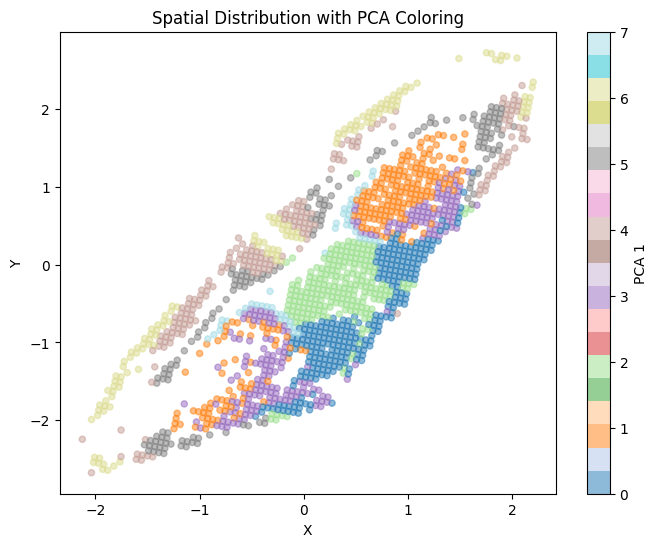

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [53]:
##############select nearst indices
import random
selected_indices = np.random.choice(31185, 3734, replace=False)
selected_indices = np.random.choice(2438, 1463, replace=False)
def func1(selected_indices):
   X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
    X1_label[X1_label == 3] = 10
    # 将除了12和13之外的所有值都替换为100
    X1_label[~np.isin(X1_label, 10)] = 11
    print(X1_label)
    X3_label = adata1.obs["leiden"].to_numpy().astype(int)
    X3_label[X3_label == 3] = 10
    # 将除了12和13之外的所有值都替换为100
    X3_label[~np.isin(X3_label, 10)] = 11

    X2_label = adata2.obs["leiden"].to_numpy().astype(int)
    X2_label[X2_label == 3] = 10
    X2_label[X2_label == 1] = 10
    # 将除了12和13之外的所有值都替换为100
    X2_label[~np.isin(X2_label,10)] = 11

    scaler = MinMaxScaler(feature_range=(-1, 1))

    data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
    scaled_data = scaler.fit_transform(data3_spatial_results)
    data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
    data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
    data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
    scaled_data = scaler.fit_transform(data2_spatial_results)
    data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
    data1_spatial_results=pd.DataFrame(data1_spatial_results)
    data2_spatial_results=pd.DataFrame(data2_spatial_results)
    data3_spatial_results=pd.DataFrame(data3_spatial_results)
    data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
    data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
    data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)

    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_data3 = convert_to_array(adata1.X)
    X_data3 = pd.DataFrame(X_data3)
    X_data3 = scaler.fit_transform(X_data3)
    X_data3 = pd.DataFrame(X_data3)
    high_variance_variables = var_select(X_data3,-100,4000000, 500)
    X_data3 = X_data3.iloc[:,high_variance_variables]
    pca = PCA()
# 对数据进行 PCA
    X3_pca = pca.fit_transform(X_data3)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
    scaled_data = scaler.fit_transform(X_3_umap_results)
    X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
    X_3_umap_results[2] = X3_label
    X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
    X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
    #X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

    X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


    X_data2 = convert_to_array(adata2.X)
    X_data2 = pd.DataFrame(X_data2)
    X_data2 = tpm_normalize(X_data2)
    X_data2 = np.log2(X_data2 + 1)
    X_data2 = pd.DataFrame(X_data2)
    high_variance_variables = var_select(X_data2,0.01,40 ,2000)
    X_data2 = X_data2.iloc[:,high_variance_variables]
    #X_data2 = scaler.fit_transform(X_data2)
    pca = PCA()
    # 对数据进行 PCA
    X2_pca = pca.fit_transform(X_data2)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
    #X_2_umap_results = pd.DataFrame(adata2.obsm["X_umap"])
    scaled_data = scaler.fit_transform(X_2_umap_results)
    X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
    #X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
    X_2_umap_results[2] = X2_label
    X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
    X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
    cca = CCA(n_components=2)
    cca.fit(X_1_umap_results,X_2_umap_results)
    X_c = cca.transform(X_1_umap_results)
    Y_c = cca.transform(X_2_umap_results)
    Z_c = cca.transform(X_3_umap_results)

    X_c=pd.DataFrame(X_c)
    Y_c=pd.DataFrame(Y_c)
    Z_c=pd.DataFrame(Z_c)

    dist_min = 0.05 ## min euclidean distance
    from scipy.spatial.distance import cdist
    distances = cdist(Z_c, Y_c, metric='euclidean')
    dist_df = pd.DataFrame(distances)
    dt_describe = dist_df.describe()
    ###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
    row_indices, col_indices = np.where(distances <dist_min)
    unique_row_indices = np.unique(row_indices)
    return unique_row_indices

def sample_and_apply(input_array,n,m):
    m = m
    output_array = []
    elements = list(input_array)  # 生成包含所有元素的列表
    
    while m > -1:  # 当列表不为空时循环
        random.shuffle(elements)  # 随机洗牌
        sample = elements[:n]  # 从列表中随机抽取 n 个元素
        output_array.append(func1(sample))  # 将输出值存储在新数组中
        m = m-1
    return output_array
output_array = sample_and_apply(range(2438), 1463,1)
print("select indice finished")


I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


select indice finished


In [22]:
print(len(output_array))
array_lengths = [len(arr) for arr in output_array]
# 打印每个数组的长度
for i, length in enumerate(array_lengths):
    print("Length of array", i+1, ":", length)
merged_array = np.concatenate(output_array)
merged_array = np.unique(merged_array)
print(len(merged_array))

2
Length of array 1 : 840
Length of array 2 : 1046
1489


In [54]:
###casual run using neasrst indices
selected_indices = np.random.choice(range(2438), 1463, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 3] = 10
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, 10)] = 11
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 3] = 10
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, 10)] = 11

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 3] = 10
X2_label[X2_label == 1] = 10
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label,10)] = 11

[10 11 11 ... 11 10 11]


In [55]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)

<bound method NDFrame.head of         0         1
0    -1.0  0.558824
1    -1.0  0.588235
2    -1.0  0.617647
3    -1.0  0.647059
4    -1.0  0.676471
...   ...       ...
2433  1.0 -0.441176
2434  1.0 -0.411765
2435  1.0 -0.382353
2436  1.0 -0.352941
2437  1.0 -0.323529

[2438 rows x 2 columns]>
<bound method NDFrame.head of              0         1
84   -0.882353  0.323529
1982  0.490196  0.117647
1958  0.490196 -0.588235
1938  0.450980  0.294118
1133 -0.098039 -0.352941
...        ...       ...
487  -0.529412 -0.441176
1704  0.294118 -0.500000
1034 -0.176471  0.264706
684  -0.411765  0.411765
2422  0.960784 -0.323529

[1463 rows x 2 columns]>


In [56]:
cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
data1_spatial_results = cca.transform(data1_spatial_results)
data2_spatial_results = cca.transform(data2_spatial_results)
data3_spatial_results = cca.transform(data3_spatial_results)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)

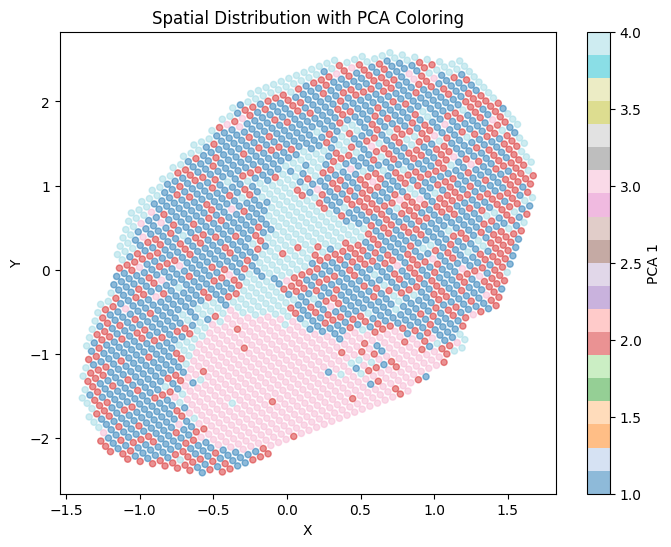

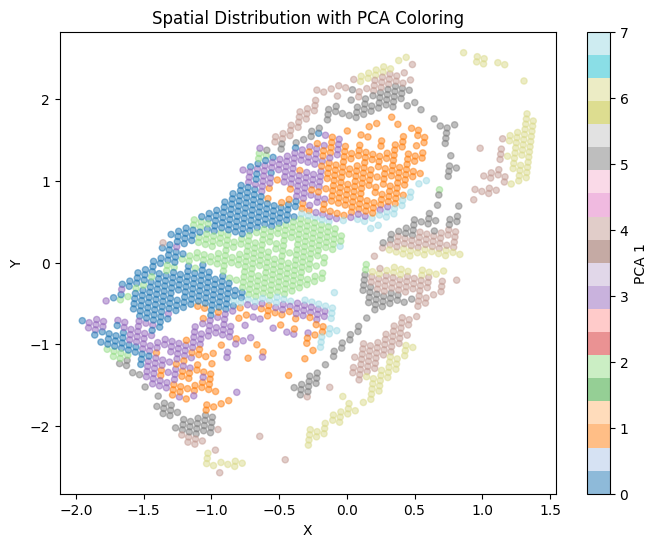

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [58]:
#####X1:metabolic subgroup 
#####X2:spatial 
#####X3:metabolic whole group
#####normalize, pca and umap of X1,X2 and X3
#####perform CCA between X1 and X2
#####fit CCA model to X1 X2 X3



pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))

#print(X_1_umap_results.head)
print(pd.DataFrame(adata1.obsm['spatial']).iloc[selected_indices,0])
X_data3 = convert_to_array(adata1.X)
X_data3 = pd.DataFrame(X_data3)
X_data3 = scaler.fit_transform(X_data3)
X_data3 = pd.DataFrame(X_data3)
high_variance_variables = var_select(X_data3,-100,40000, 500)
X_data3 = X_data3.iloc[:,high_variance_variables]
pca = PCA()
# 对数据进行 PCA
X3_pca = pca.fit_transform(X_data3)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
scaled_data = scaler.fit_transform(X_3_umap_results)
X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
X_3_umap_results[2] = X3_label
X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
#X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


X_data2 = convert_to_array(adata2.X)
X_data2 = pd.DataFrame(X_data2)
X_data2 = tpm_normalize(X_data2)
X_data2 = np.log2(X_data2 + 1)
X_data2 = pd.DataFrame(X_data2)
high_variance_variables = var_select(X_data2,0.01,40 ,2000)
X_data2 = X_data2.iloc[:,high_variance_variables]
#X_data2 = scaler.fit_transform(X_data2)
pca = PCA()
# 对数据进行 PCA
X2_pca = pca.fit_transform(X_data2)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
#X_2_umap_results = pd.DataFrame(adata2.obsm["X_umap"])
scaled_data = scaler.fit_transform(X_2_umap_results)
X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
X_2_umap_results[2] = X2_label
X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
cca = CCA(n_components=2)
cca.fit(X_1_umap_results,X_2_umap_results)
X_c = cca.transform(X_1_umap_results)
Y_c = cca.transform(X_2_umap_results)
Z_c = cca.transform(X_3_umap_results)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

84       3
1982    38
1958    38
1938    37
1133    23
        ..
487     12
1704    33
1034    21
684     15
2422    50
Name: 0, Length: 1463, dtype: int64


I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


I:\mutiomics\pythonProject\.venv\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1463, 2)


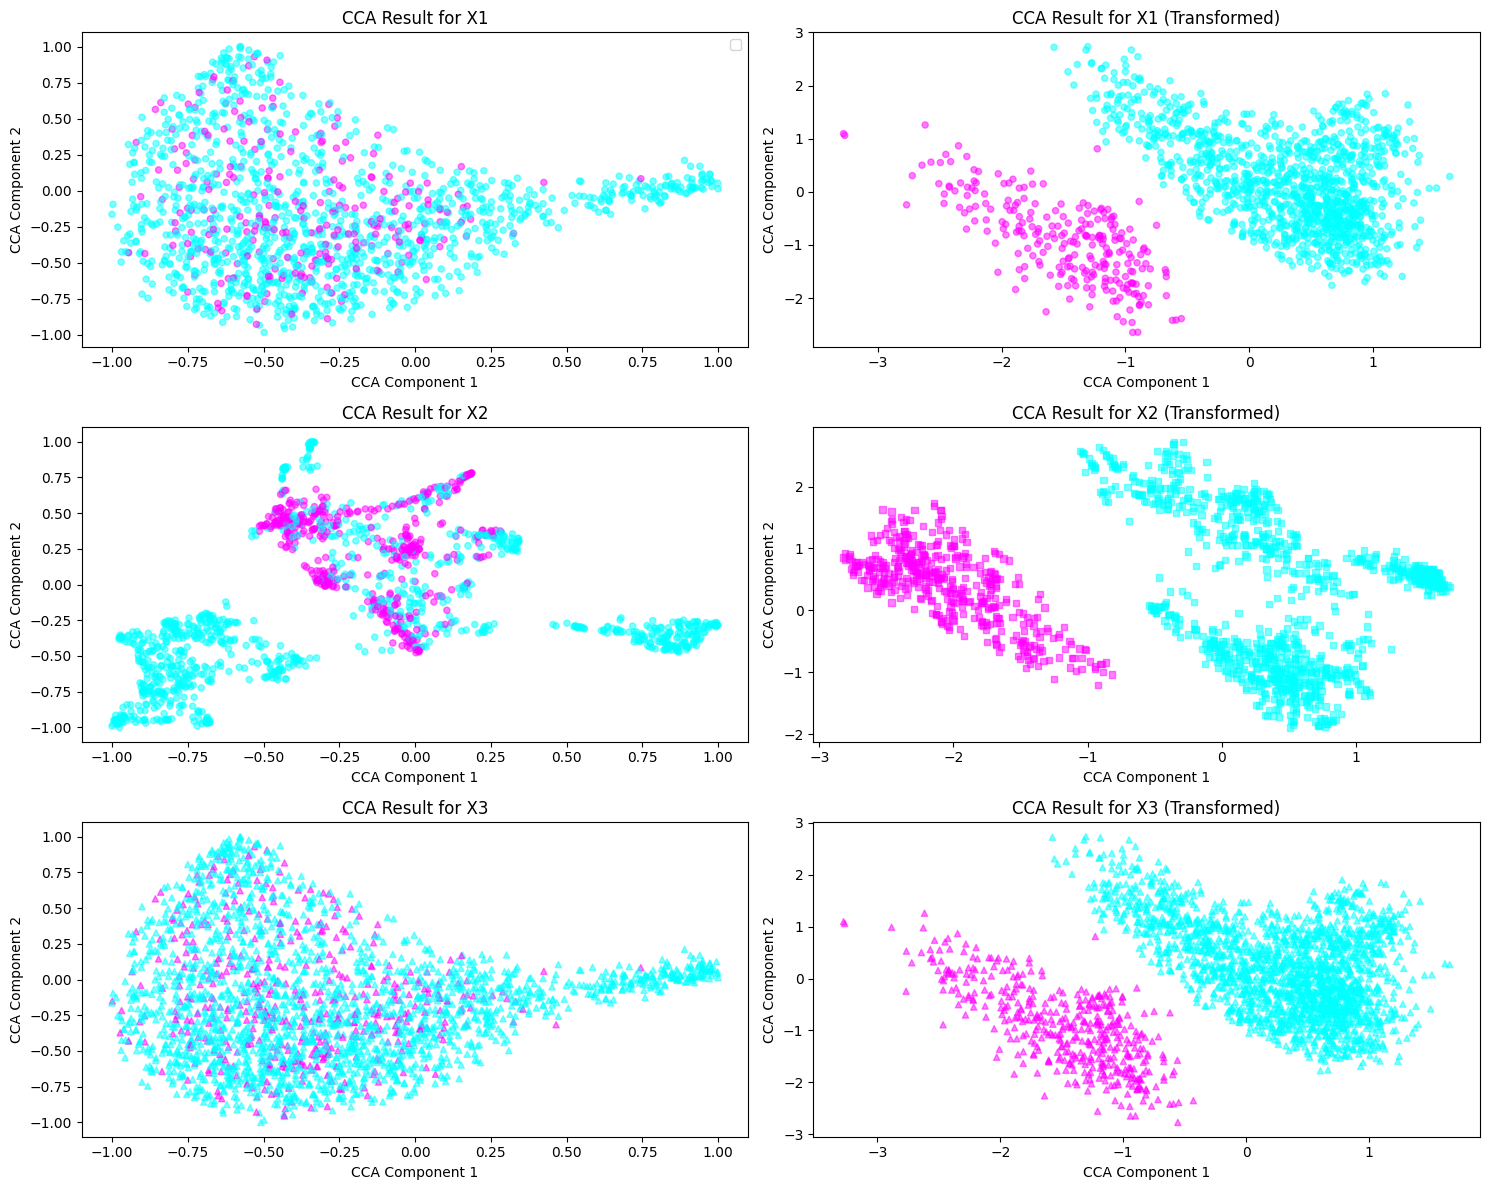

In [59]:
print(X_c.shape)
import matplotlib.pyplot as plt


#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'cyan',
    12: 'blue',
    13: 'red',
    14: 'green',
    15: 'yellow'
}

# 假设 X_c 和 Y_c 是 CCA 转换后的结果
# 在这个示例中，假设 X_c 和 Y_c 都是二维数据

plt.figure(figsize=(15, 12))

# 绘制 X1 的散点图
plt.subplot(3, 2, 1)
scatter = plt.scatter(X_1_umap_results.iloc[:, 0], X_1_umap_results.iloc[:, 1],
                     # c=[color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)],
                      c=[color_mapping[category] for category in X1_label],
                      s=20, alpha=0.5)
unique_categories = np.unique(data1_leiden_str[selected_indices].astype(int))
legend_labels = [f'Category {cat}' for cat in unique_categories]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.title('CCA Result for X1')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')


# 绘制 X1 转换后的散点图
plt.subplot(3, 2, 2)
plt.scatter(X_c.iloc[:, 0], X_c.iloc[:, 1], 
          #  c= [color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)], 
            c= [color_mapping[category] for category in X1_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X1 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 的散点图
plt.subplot(3, 2, 3)
plt.scatter(X_2_umap_results.iloc[:, 0], X_2_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data2_leiden_str.astype(int)],
            c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X2')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 转换后的散点图
plt.subplot(3, 2, 4)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], 
             c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5, marker='s')
plt.title('CCA Result for X2 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 的散点图
plt.subplot(3, 2, 5)
plt.scatter(X_3_umap_results.iloc[:, 0], X_3_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data1_leiden_str.astype(int)],
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 转换后的散点图
plt.subplot(3, 2, 6)
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data1_leiden_str.astype(int)] , 
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

plt.tight_layout()
plt.show()

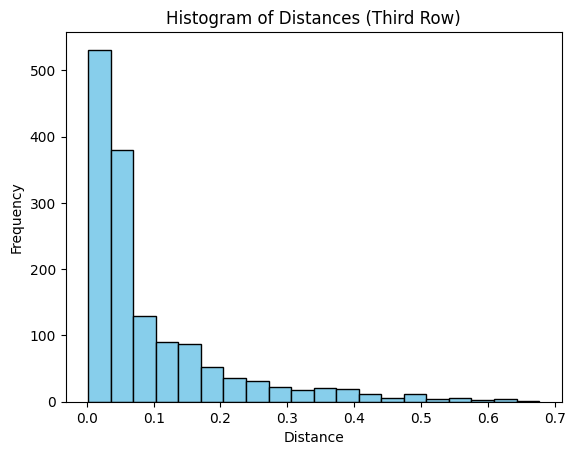

C:\Users\28123\AppData\Local\Temp\ipykernel_5552\2189755017.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\28123\AppData\Local\Temp\ipykernel_5552\2189755017.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(184968,) (184968,)
(2306,)
(1443,)
            0         1
0    1.092167 -0.058508
57   0.846281 -0.015782
109  1.289672  0.669969
127  1.480093  0.429555
139  0.706346  0.533623
          0         1
0  1.092665  0.226843
0  1.092665  0.226843
0  1.092665  0.226843
0  1.092665  0.226843
0  1.092665  0.226843
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z
0       1.092167      -0.058508           0                4             -1
1       0.846281      -0.015782          57                5             -1
2       1.289672       0.669969         109                2             -1
3       1.480093       0.429555         127                2             -1
4       0.706346       0.533623         139                0             -1
   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0         1.092665         0.226843             0                  2   
1         1.092665         0.226843             0                  2   
2         1.0926

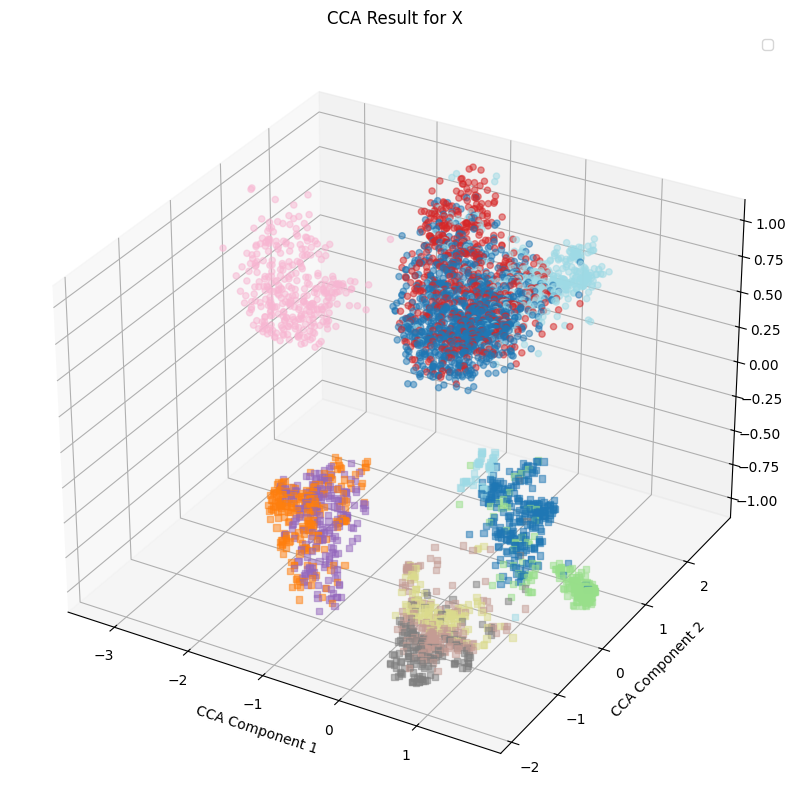

In [60]:
####select nearst neighbour groups of sample pairs between X1 and X3
####
dist_min = 0.5 ## min euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
dt_describe = dist_df.describe()
plt.hist(dt_describe.iloc[3,], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances (Third Row)')
plt.show()
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
row_indices, col_indices = np.where(distances <dist_min)
unique_row_indices = np.unique(row_indices)
unique_col_indices = np.unique(col_indices)
#############plot
####Z_C is metablic and is at 1
print(row_indices.shape, col_indices.shape)
print(unique_row_indices.shape)
print(unique_col_indices.shape)
print(Y_c.iloc[col_indices,].head())
print(Z_c.iloc[row_indices,].head())
Y_C_=Y_c.iloc[col_indices,]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_=Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_=Y_C_.drop(columns=['index'])
Y_C_=Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})

Z_C_=Z_c.iloc[row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})

print(Y_C_.head())
print(Z_C_.head())
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()


In [61]:
import pandas as pd

def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    # 保存每个 X1 中值对应的 X2 中值的列表
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()

    # 计算每个 X1 中值的辛普森指数
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)

    # 保存每个 X1 中值对应的 X2 中出现频率最高的值
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))

    # 生成新的 DataFrame
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})

    # 合并 X3 列
    new_df = pd.merge(new_df, df[['spatial_ID',"spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')

    return new_df

# 示例输入数据
data = pairs
df = pd.DataFrame(data)

# 调用主函数
result_df = main(df)
print("新的 DataFrame:")
print(result_df)


新的 DataFrame:
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            1       0.570291                4
1              1                            2       0.000000                2
2              2                            1       0.389904                6
3              3                            4       0.291667                0
4              4                            4       0.655138                2
...          ...                          ...            ...              ...
1438        1458                            4       0.558750                0
1439        1459                            1       0.281728                5
1440        1460                            1       0.400712                5
1441        1461                            1       0.365671                6
1442        1462                            2       0.539259                0

[1443 rows x 4 columns]


<bound method NDFrame.head of         0         1
0    -1.0  0.558824
1    -1.0  0.588235
2    -1.0  0.617647
3    -1.0  0.647059
4    -1.0  0.676471
...   ...       ...
2433  1.0 -0.441176
2434  1.0 -0.411765
2435  1.0 -0.382353
2436  1.0 -0.352941
2437  1.0 -0.323529

[2438 rows x 2 columns]>
<bound method NDFrame.head of              0         1
84   -0.882353  0.323529
1982  0.490196  0.117647
1958  0.490196 -0.588235
1938  0.450980  0.294118
1133 -0.098039 -0.352941
...        ...       ...
487  -0.529412 -0.441176
1704  0.294118 -0.500000
1034 -0.176471  0.264706
684  -0.411765  0.411765
2422  0.960784 -0.323529

[1463 rows x 2 columns]>


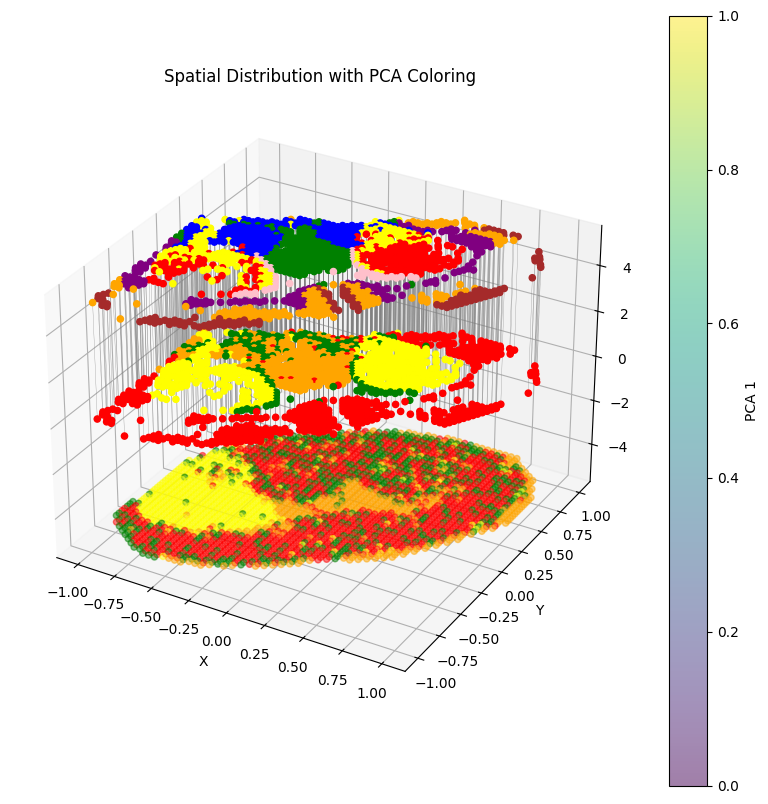

In [62]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data2_pca_results = adata2.obsm['spatial']
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1], zs=0,
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in result_df["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

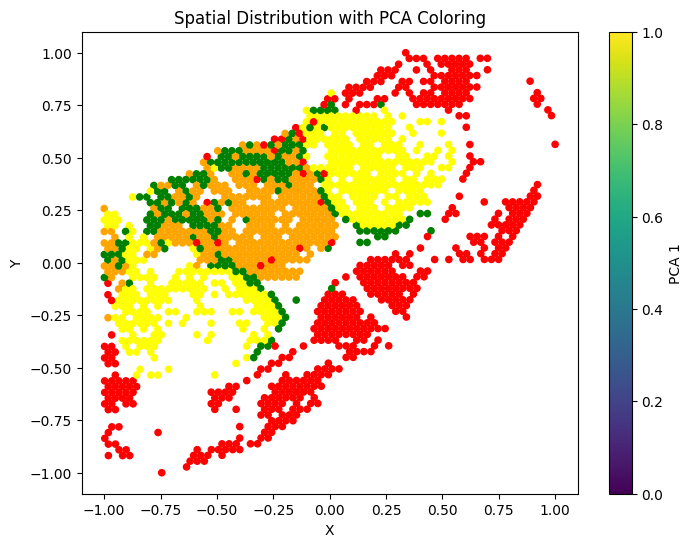

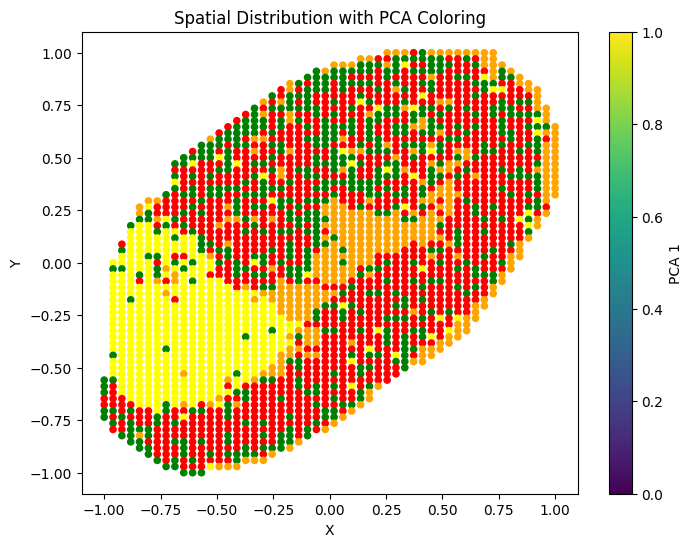

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1],
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

C:\Users\28123\AppData\Local\Temp\ipykernel_5552\318621266.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data1_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)


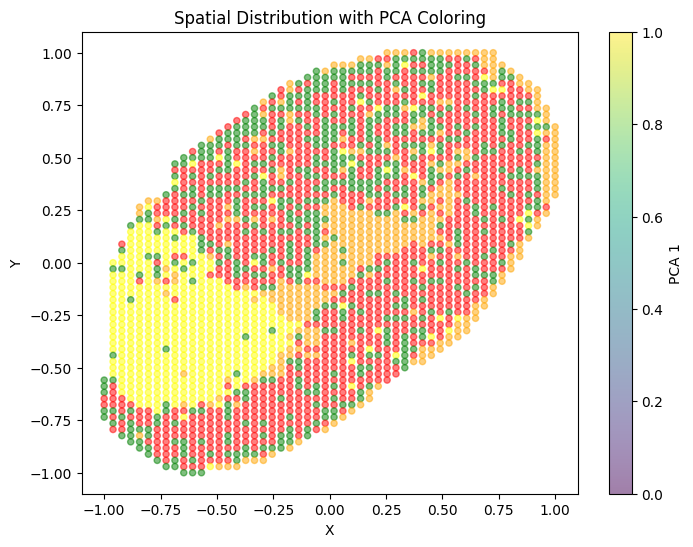

C:\Users\28123\AppData\Local\Temp\ipykernel_5552\318621266.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)


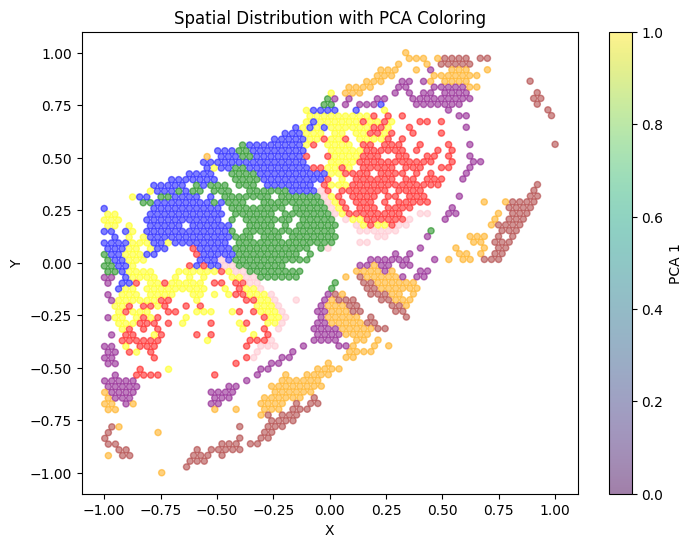

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data1_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

C:\Users\28123\AppData\Local\Temp\ipykernel_5552\808405300.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2438, 2) (1463, 2)
(2438, 1463)
(2438, 2) (1463, 2)
(2438, 2) (1463, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0       1.092167      -0.058508           0                4             -1   
1      -0.393946       2.369493           1                2             -1   
2       0.005442      -0.505080           2                6             -1   
3       0.263473       1.819920           3                0             -1   
4       0.361388       0.915694           4                2             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0         1.148482        -0.042819           481                  2   
1        -0.713530         2.245673          1173                  2   
2         0.020008        -0.531838          2047                  1   
3         0.550342         1.676922          2420                  4   
4         0.338396         0.944585          1823                  1   

   matabolic.CCA.Z 

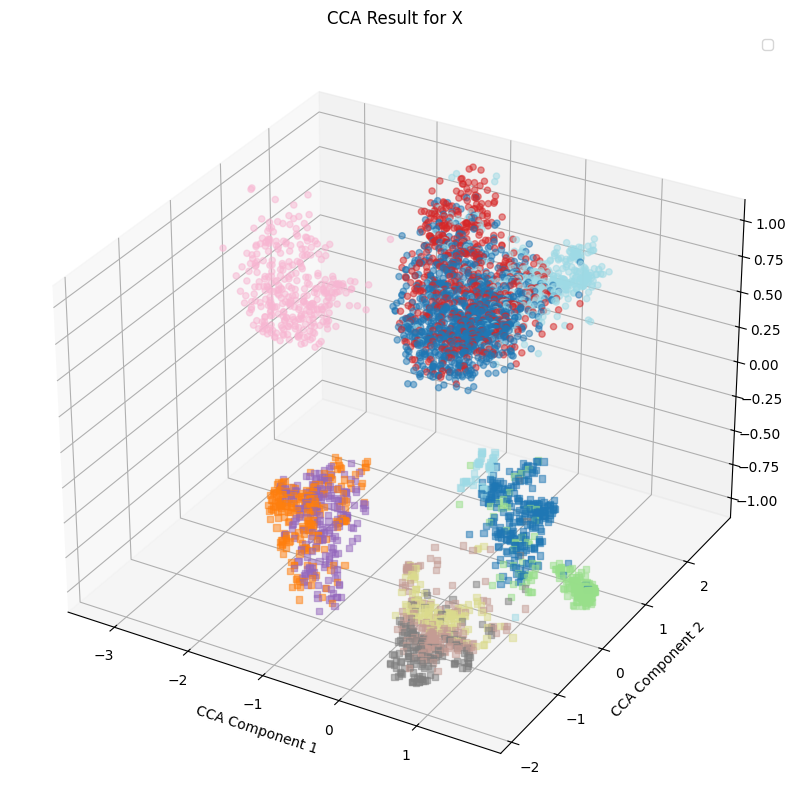

In [65]:
####select nearst neighbour of sample pairs between X1 and X3
####
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

<bound method NDFrame.head of         0         1
0    -1.0  0.558824
1    -1.0  0.588235
2    -1.0  0.617647
3    -1.0  0.647059
4    -1.0  0.676471
...   ...       ...
2433  1.0 -0.441176
2434  1.0 -0.411765
2435  1.0 -0.382353
2436  1.0 -0.352941
2437  1.0 -0.323529

[2438 rows x 2 columns]>
<bound method NDFrame.head of              0         1
84   -0.882353  0.323529
1982  0.490196  0.117647
1958  0.490196 -0.588235
1938  0.450980  0.294118
1133 -0.098039 -0.352941
...        ...       ...
487  -0.529412 -0.441176
1704  0.294118 -0.500000
1034 -0.176471  0.264706
684  -0.411765  0.411765
2422  0.960784 -0.323529

[1463 rows x 2 columns]>


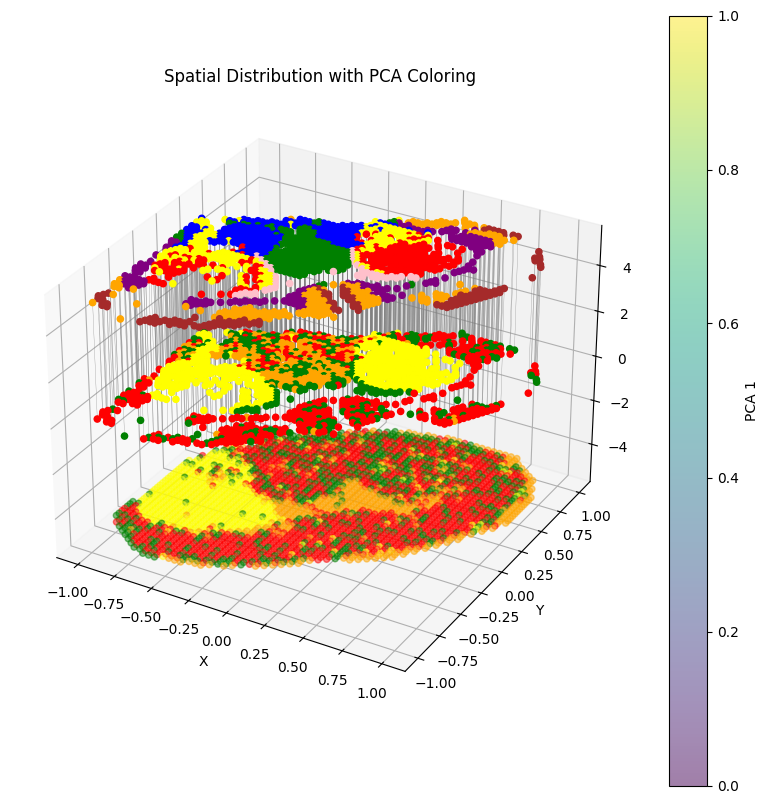

In [66]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data2_pca_results = adata2.obsm['spatial']
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], zs=0,
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in pairs["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

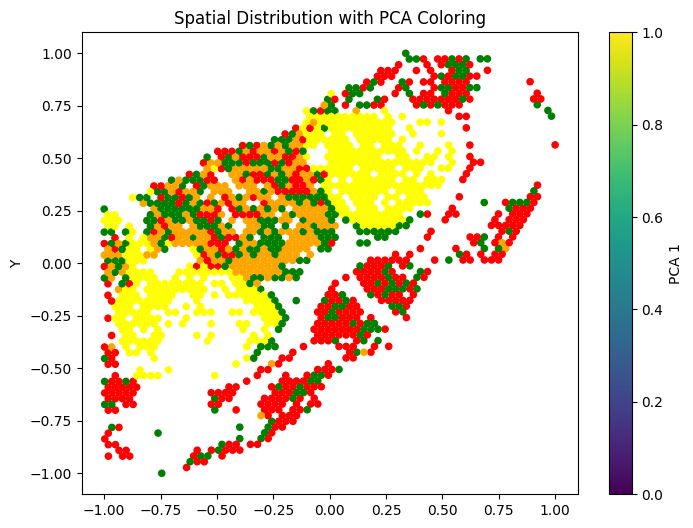

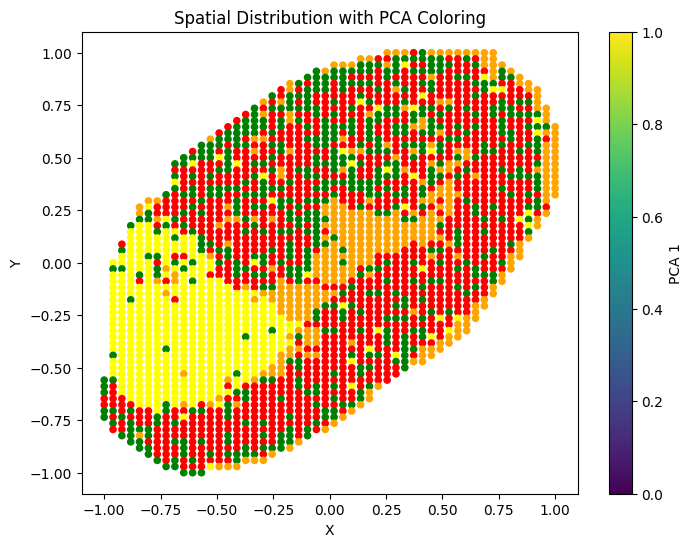

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

1          1
2          2
3          3
6          6
7          7
        ... 
1435    1455
1436    1456
1437    1457
1439    1459
1441    1461
Name: spatial_ID, Length: 873, dtype: int64
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  \
1              1                            2       0.000000   
2              2                            1       0.389904   
3              3                            4       0.291667   
6              6                            1       0.356450   
7              7                            1       0.351469   
...          ...                          ...            ...   
1435        1455                            3       0.000000   
1436        1456                            1       0.370473   
1437        1457                            2       0.000000   
1439        1459                            1       0.281728   
1441        1461                            1       0.365671   

      spatial_cluster_x  spatial.CCA.X  spat

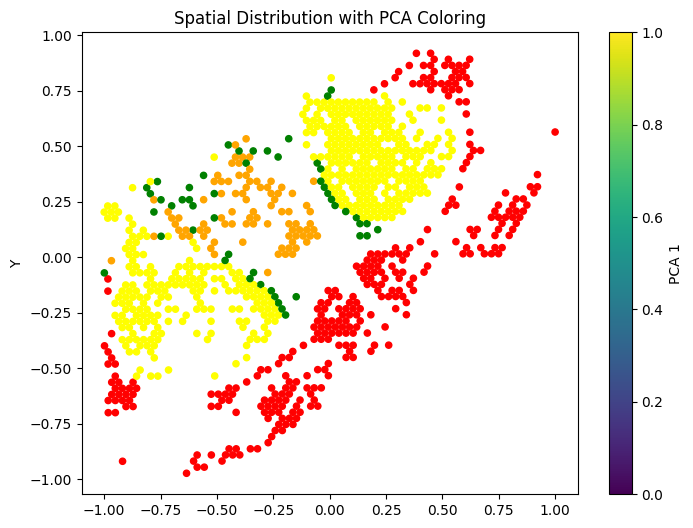

In [71]:
###### find transcript-metaboic pairs anchors by filtering: 
######1/simpson index less than 0.2 2/Most_freq_metabolic_cluster==matabolic_cluster
#print(result_df.head)
#print(pairs.head)
merged_df = pd.merge(result_df, pairs, on='spatial_ID', how='inner')
merged_df = pd.DataFrame(merged_df)
merged_df = merged_df[(merged_df['Simpson_Index'] < 0.4) & (merged_df['Most_freq_metabolic_cluster'] == merged_df['matabolic_cluster'])]
print(merged_df["spatial_ID"])
print(merged_df)
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[merged_df["spatial_ID"], 0],data2_spatial_results.iloc[merged_df["spatial_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()


In [72]:
scaler = MinMaxScaler(feature_range=(-1, 1))
DF1 = convert_to_array(adata2.X)
DF1 = pd.DataFrame(DF1)
DF1 = tpm_normalize(DF1)
DF1 = np.log2(DF1 + 1)
DF1 = scaler.fit_transform(DF1)
DF1 = pd.DataFrame(DF1)

DF2 = convert_to_array(adata1.X)
DF2 = pd.DataFrame(DF2)
DF2 = scaler.fit_transform(DF2)
DF2 = pd.DataFrame(DF2)

print(DF1.shape,DF2.shape)
spatial_ID_list = merged_df['spatial_ID'].tolist()
metabolic_ID_list = merged_df['matabolic_ID'].tolist()

# 从 DF1 和 DF2 中提取对应的样本
spatial_samples = DF1.loc[spatial_ID_list,:]
index_strings = adata2.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(spatial_samples.columns, index_strings)}
spatial_samples.rename(columns=column_mapping, inplace=True)
rowindex = spatial_samples.shape[0]
spatial_samples.index = range(rowindex)

metabolic_samples = DF2.loc[metabolic_ID_list,:]
rowindex = metabolic_samples.shape[0]
index_strings = adata1.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(metabolic_samples.columns, index_strings)}
metabolic_samples.rename(columns=column_mapping, inplace=True)
metabolic_samples.index = range(rowindex)

print(spatial_samples.shape,metabolic_samples.shape,pd.concat([spatial_samples, metabolic_samples], axis=0).shape)
# 计算特征之间的相关性

(1463, 14369) (2438, 1538)
(873, 14369) (873, 1538) (1746, 15907)


In [73]:
correlation_matrix = pd.concat([spatial_samples, metabolic_samples], axis=1)
correlation_matrix = correlation_matrix.corr()
# 显示相关性矩阵
print("DF1 列变量与 DF2 列变量之间的相关性矩阵：")
# 显示 DF3
#print(DF3)

DF1 列变量与 DF2 列变量之间的相关性矩阵：


(14369, 1538)


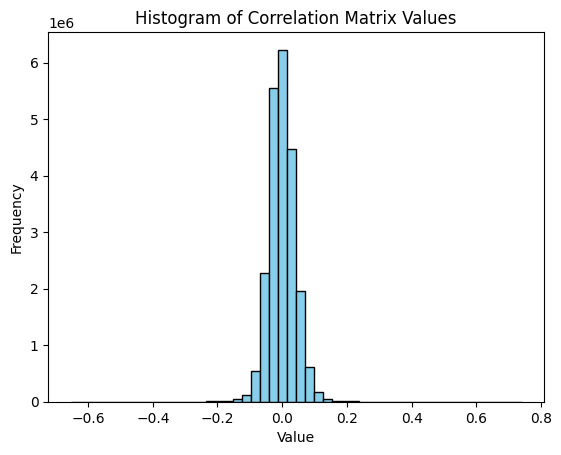

大于0.8的行：
12

大于0.8的列：
12
相关性大于0.8的值：
[2520, 2520, 7260, 7260, 8137, 8137, 9347, 9347, 9522, 9522, 10032, 10032]
12
156.26059    -0.826678
156.26195    -0.734735
156.48344    -0.781721
156.4838     -0.713769
156.485      -0.674572
                ...   
1046.36442   -0.890717
1048.32025   -0.931639
1048.3319    -0.765108
1048.34354   -0.624842
1048.38431   -0.837918
Length: 1538, dtype: float64
[1052, 1053, 1052, 1053, 1052, 1053, 1052, 1053, 1052, 1053, 1052, 1053]


In [81]:
correlation_matrix2 = correlation_matrix.iloc[:14369, -1538:]
print(correlation_matrix2.shape)

values = correlation_matrix2.values.flatten()
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()
high_correlation_spatial = []
high_correlation_metabolic = []

# 遍历相关性矩阵的所有元素
indices = (correlation_matrix2 < 1) & (correlation_matrix2 > 0.7)
high_corr_indices = indices.values.nonzero()
# 将行和列索引分别存储到两个列表中
high_correlation_spatial = high_corr_indices[0].tolist()
high_correlation_metabolic = high_corr_indices[1].tolist()
#high_correlation_spatial = correlation_matrix2.index[correlation_matrix2.apply(lambda x: x > 0.8).any(axis=1)]
#high_correlation_spatial = set(high_correlation_spatial)
#high_correlation_metabolic = correlation_matrix2.columns[correlation_matrix2.apply(lambda x: x > 0.8).any(axis=0)]
#high_correlation_metabolic = set(high_correlation_metabolic)
# 显示满足条件的行和列
print("大于0.8的行：")
print(len(high_correlation_spatial))
print("\n大于0.8的列：")
print(len(high_correlation_metabolic))
# 显示满足条件的值
print("相关性大于0.8的值：")


column_means = spatial_samples.mean()
columns_to_remove = column_means[column_means < 0].index
filtered_high_correlation_spatial = [col for col in high_correlation_spatial if col not in columns_to_remove]
print(filtered_high_correlation_spatial)
print(len(filtered_high_correlation_spatial))
column_means = metabolic_samples.mean()
print(column_means)
columns_to_remove = column_means[column_means < -1].index
filtered_high_correlation_metabolic = [col for col in high_correlation_metabolic if col not in columns_to_remove]
print(filtered_high_correlation_metabolic)


In [82]:
scaler = MinMaxScaler(feature_range=(-1, 1))

metabolic_select_high_corr_variant = convert_to_array(adata1.X)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = scaler.fit_transform(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = metabolic_select_high_corr_variant.iloc[:,high_correlation_metabolic]
metabolic_select_high_corr_variant = pd.concat([X_3_umap_results, metabolic_select_high_corr_variant], axis=1)
print(metabolic_select_high_corr_variant.shape)
metabolic_select_high_corr_variant_X1 = metabolic_select_high_corr_variant.iloc[selected_indices,]

spatial_select_high_corr_variant = convert_to_array(adata2.X)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = scaler.fit_transform(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = spatial_select_high_corr_variant.iloc[:,high_correlation_spatial]
spatial_select_high_corr_variant = pd.concat([X_2_umap_results, spatial_select_high_corr_variant], axis=1)
print(spatial_select_high_corr_variant.shape)



(2438, 17)
(1463, 17)


In [83]:
cca = CCA(n_components=17)
cca.fit(spatial_select_high_corr_variant,metabolic_select_high_corr_variant_X1)
X_c = cca.transform(metabolic_select_high_corr_variant_X1)
Y_c = cca.transform(spatial_select_high_corr_variant)
Z_c = cca.transform(metabolic_select_high_corr_variant)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

I:\mutiomics\pythonProject\.venv\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 8
  warnings.warn(f"Y residual is constant at iteration {k}")


C:\Users\28123\AppData\Local\Temp\ipykernel_5552\808405300.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2438, 17) (1463, 17)
(2438, 1463)
(2438, 17) (1463, 17)
(2438, 17) (1463, 17)
   spatial.CCA.X  spatial.CCA.Y         2         3         4         5  \
0      -0.682960      -1.754965 -0.255491 -0.448303  0.395150 -0.933950   
1       0.751721      -0.684386  0.719392  0.484251 -0.636001 -0.777231   
2       0.254278      -0.127787 -0.176095  0.535646 -0.892460  1.303075   
3       0.778025       0.810195 -0.254029 -0.400889  0.032165 -0.308757   
4      -0.028380       0.591769  1.258686 -0.403936 -0.225870 -1.104646   

          6         7    8    9  ...   10   11   12   13   14   15   16  \
0  0.452754  0.018259  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1 -1.321545 -0.032201  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2 -0.727531  0.011779  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3 -0.193826  0.042706  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4 -0.206696 -0.006618  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   matabolic_ID  ma

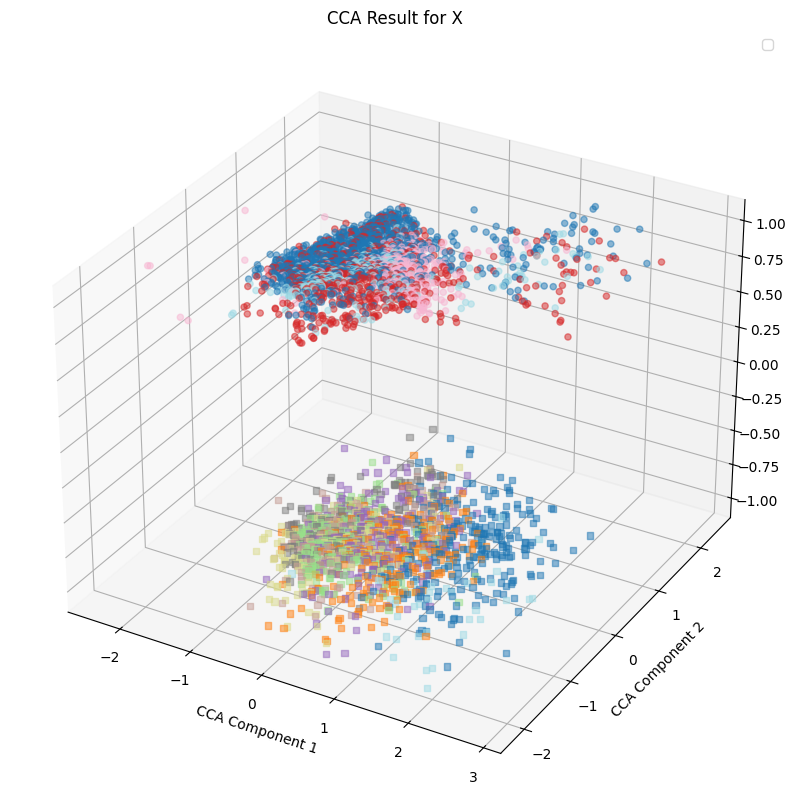

In [84]:
####select nearst neighbour of sample pairs between X1 and X3
####
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

<bound method NDFrame.head of         0         1
0    -1.0  0.558824
1    -1.0  0.588235
2    -1.0  0.617647
3    -1.0  0.647059
4    -1.0  0.676471
...   ...       ...
2433  1.0 -0.441176
2434  1.0 -0.411765
2435  1.0 -0.382353
2436  1.0 -0.352941
2437  1.0 -0.323529

[2438 rows x 2 columns]>
<bound method NDFrame.head of              0         1
84   -0.882353  0.323529
1982  0.490196  0.117647
1958  0.490196 -0.588235
1938  0.450980  0.294118
1133 -0.098039 -0.352941
...        ...       ...
487  -0.529412 -0.441176
1704  0.294118 -0.500000
1034 -0.176471  0.264706
684  -0.411765  0.411765
2422  0.960784 -0.323529

[1463 rows x 2 columns]>


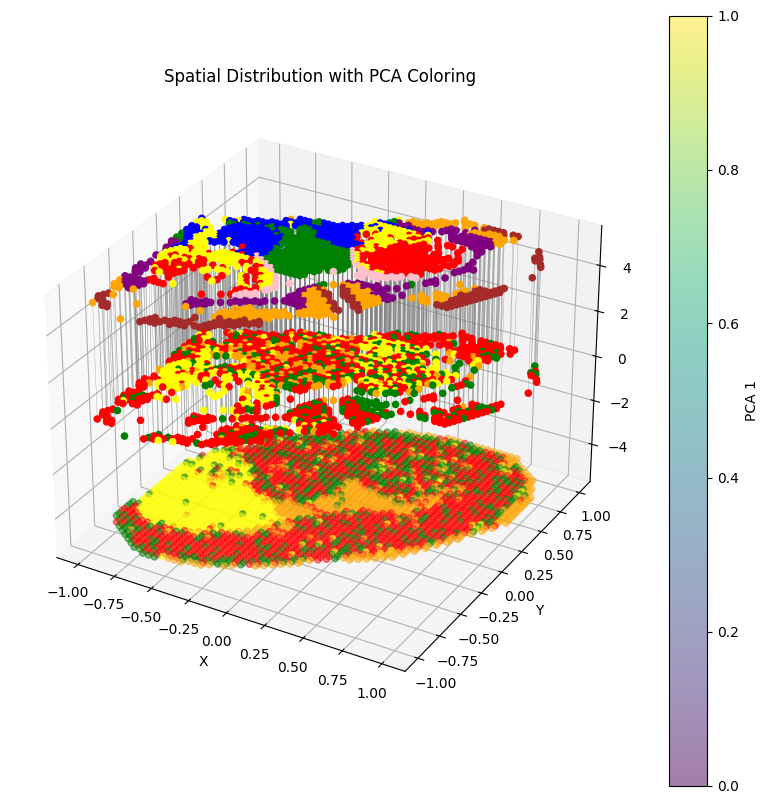

In [85]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data2_pca_results = adata2.obsm['spatial']
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], zs=0,
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in pairs["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

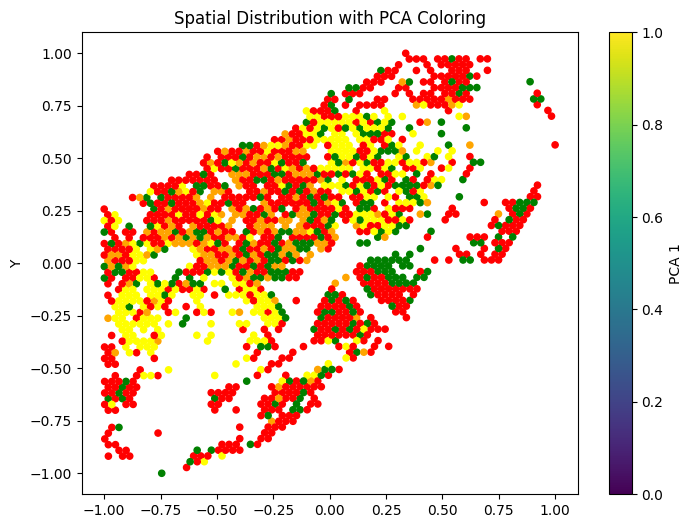

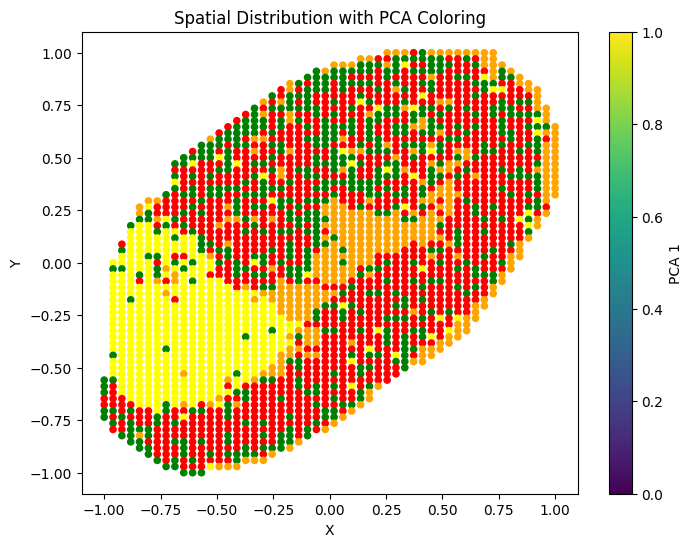

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()